<a href="https://colab.research.google.com/github/zeineb12/text_classification/blob/master/basic_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Relevant-imports" data-toc-modified-id="Relevant-imports-1">Relevant imports</a></span></li><li><span><a href="#Dataset-shape" data-toc-modified-id="Dataset-shape-2">Dataset shape</a></span><ul class="toc-item"><li><span><a href="#Drop-duplicates" data-toc-modified-id="Drop-duplicates-2.1">Drop duplicates</a></span></li></ul></li><li><span><a href="#Tweets-length" data-toc-modified-id="Tweets-length-3">Tweets length</a></span></li><li><span><a href="#Data-concatenation" data-toc-modified-id="Data-concatenation-4">Data concatenation</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-5">Data Cleaning</a></span></li><li><span><a href="#Word-cloud-TODO" data-toc-modified-id="Word-cloud-TODO-6">Word cloud TODO</a></span></li><li><span><a href="#Split-train/validation/test" data-toc-modified-id="Split-train/validation/test-7">Split train/validation/test</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-8">Baseline</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-using-CountVectorizer" data-toc-modified-id="Naive-Bayes-using-CountVectorizer-8.1">Naive Bayes using CountVectorizer</a></span></li><li><span><a href="#Prepare-tfidf-matrix" data-toc-modified-id="Prepare-tfidf-matrix-8.2">Prepare tfidf matrix</a></span></li><li><span><a href="#Naive-Bayes-using-TfidfTransformer" data-toc-modified-id="Naive-Bayes-using-TfidfTransformer-8.3">Naive Bayes using TfidfTransformer</a></span></li><li><span><a href="#SGDClassifier--using-TfidfTransformer" data-toc-modified-id="SGDClassifier--using-TfidfTransformer-8.4">SGDClassifier  using TfidfTransformer</a></span></li><li><span><a href="#SVC-using-TfidfTransformer" data-toc-modified-id="SVC-using-TfidfTransformer-8.5">SVC using TfidfTransformer</a></span></li><li><span><a href="#Logistic-Regression-using-TfidfTransformer" data-toc-modified-id="Logistic-Regression-using-TfidfTransformer-8.6">Logistic Regression using TfidfTransformer</a></span></li></ul></li><li><span><a href="#Feature-engineering-(can-later-test-on-NN-model)" data-toc-modified-id="Feature-engineering-(can-later-test-on-NN-model)-9">Feature engineering (can later test on NN model)</a></span><ul class="toc-item"><li><span><a href="#Stop-words" data-toc-modified-id="Stop-words-9.1">Stop words</a></span></li><li><span><a href="#N-Grams" data-toc-modified-id="N-Grams-9.2">N Grams</a></span></li></ul></li><li><span><a href="#Test-submission" data-toc-modified-id="Test-submission-10">Test submission</a></span></li></ul></div>

## Relevant imports

In [70]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from wordcloud import WordCloud

from nltk.tokenize import WordPunctTokenizer
#from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

from utils import open_by_tweets
from utils import create_csv_submission

SEED = 15432

## Dataset shape

In [85]:
with open('data/train_pos_full.txt',"r") as file:
#with open('data/train_pos.txt',"r") as file:
    train_pos = file.read().split('\n')
train_pos = pd.DataFrame({'tweet' : train_pos})[:len(train_pos)-1]

with open('data/train_neg_full.txt',"r") as file:
#with open('data/train_neg.txt',"r") as file:
    train_neg = file.read().split('\n')
train_neg = pd.DataFrame({'tweet' : train_neg})[:len(train_neg)-1]

### Drop duplicates
Let's drop duplicates from our dataset

In [86]:
train_neg.drop_duplicates(inplace=True)
train_pos.drop_duplicates(inplace=True)

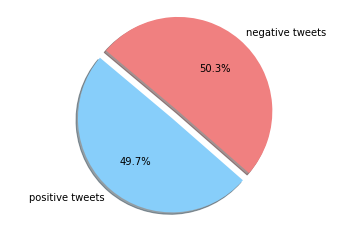

In [87]:
# Data to plot
labels = 'positive tweets', 'negative tweets'
sizes = [len(train_pos), len(train_neg)]
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

We see that the dataset is balanced

## Tweets length
* We add a column containing the tweet length for each tweet (in number of characters)

In [88]:
train_neg['tweet_len'] = [len(t) for t in train_neg.tweet]
train_pos['tweet_len'] = [len(t) for t in train_pos.tweet]

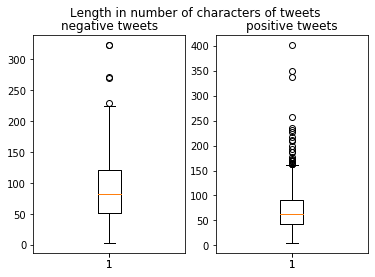

In [89]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)

ax = axs[0]
ax.boxplot(train_neg.tweet_len, whis=1.5)
ax.set_title('negative tweets')

ax = axs[1]
ax.boxplot(train_pos.tweet_len, whis=1.5)
ax.set_title('positive tweets')

fig.suptitle('Length in number of characters of tweets')
plt.show()

* We see that positive tweets tend to be shorter than negative tweets (mean and std are both smaller)

* However, something that's a bit strange, some of the tweets are way more than 140 characters long. But twitter’s character limit is 140.

In [90]:
train_pos[train_pos.tweet_len > 200].head(4)

,tweet,tweet_len
19278,""" <user> have so much fun at prom <user> \ 355...",217
212494,party at your house ? bap bap ! lml rt <user> ...,401
231749,"hahaha , thanks it's the truth though ! :p "" <...",209
338769,rt <user> curls n curves \ 355 \ 240 \ 275 \ 3...,338


In [91]:
train_pos.loc[19278].tweet

'" <user> have so much fun at prom <user> \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 227 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 221 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 217 \\ 355 \\ 240 \\ 275 \\ 355 \\ 262 \\ 213 " yayyy shanny ! ! ! #dodaadirty'

Maybe these numbers used to stand for emojis and when the html text was processed they becaùe like these

In [20]:
re.sub(r'\\ [0-9]+ ','',train_pos.loc[19278].tweet)

'" <user> have so much fun at prom <user> " yayyy shanny ! ! ! #dodaadirty'

## Data concatenation

In [92]:
train_pos['label'] = 1
train_neg['label'] = 0
train_set = train_pos.append(train_neg)
train_set.head(6)

,tweet,tweet_len,label
0,<user> i dunno justin read my mention or not ....,127,1
1,"because your logic is so dumb , i won't even c...",91,1
2,""" <user> just put casper in a box ! "" looved t...",69,1
3,<user> <user> thanks sir > > don't trip lil ma...,78,1
4,visiting my brother tmr is the bestest birthda...,66,1
5,<user> yay ! ! #lifecompleted . tweet / facebo...,73,1


## Data Cleaning

In [22]:
#train_set[train_set['tweet'].str.contains(':\*')]#.loc[96380].tweet

In [98]:
def replace_exclamations(x):
    """ Replaces multiple exclamation marks by the word exclamationMark """
    x = re.sub('(\! )+(?=(\!))', '', x)
    x = re.sub(r"(\!)+", ' exclamationMark ', x)
    return x


def replace_questions(x):
    """ Replaces multiple question marks by the word questionMark """
    x = re.sub('(\? )+(?=(\?))', '', x)
    x = re.sub(r"(\?)+", ' questionMark ', x)
    return x

def tokenization(text):
    text = re.split('\W+', text)
    return text

def lemmatizer(l,text):
    text = [l.lemmatize(word) for word in text]
    return text

def join_tokens(tokens):
    text = ' '.join(tokens)
    return text

def replace_points(x):
    """ Replaces multiple points by the word multiplePoints """
    x = re.sub('(\. )+(?=(\.))', '', x)
    x = re.sub(r"(\.)+", ' multistop ', x)
    return x

def translate_emojis(x):
    """ Replace emojis into meaningful words """
    
    x = re.sub(' [:,=,8]( )*(\')*( )*(-)*( )*[\),\],},D,>,3,d] ', ' happy ', x) #:) :D :} :] :> :') :'D :-D :-)
    x = re.sub(' [:,=,8]( )*$ ', ' confused ', x) #=$ 8$
    x = re.sub(' [:,=,8]( )*(\')*( )*(-)*( )*[\(,\[,{,<] ', ' sad ', x) #:( :{ :[ :< :'(
    x = re.sub(' [\),\],},D,>,d]( )*(-)*( )*(\')*( )*[:,=,8] ', ' sad ', x) #):  D: )':  D':
    x = re.sub(' [X,x]( )*D ', ' funny ', x) #XD xD
    x = re.sub(' [:,=,8]( )*(-)*( )*p ', ' silly ', x) #:p :-p
    x = re.sub(' q( )*(-)*( )*[:,=,8] ', ' silly ', x) #q:
    x = re.sub(' >( )*.( )*< ', ' sad ', x) #>.<
    x = re.sub(' ^( )*(_)+( )*^ ', ' happy ', x) #^__^
    x = re.sub(' ^( )*[.,~]( )*^ ', ' happy ', x) #^.^ ^ ~ ^  
    x = re.sub(' [\[,\(,{,<]( )*[:,=,8] ', ' happy ', x) #[:
    x = re.sub(' [:,=,8]( )*(-)*( )*[o,0] ', ' surprised ', x) #:o :-O
    x = re.sub(' [x,X]+ ', ' kiss ', x) #xXxX
    x = re.sub(' ([x,X][o,O]){2,} ', ' kiss ', x) #xoxo
    x = re.sub(' [:,=,8]( )*\* ', ' kiss ', x) #:* =*
    x = re.sub(' [:,=,8]( )*(-)*( )*[\/,\\,|] ', ' confused ', x) #:/ :\
    x = re.sub(' [\/,\\,|]( )*(-)*( )*[:,=,8] ', ' confused ', x) #/: \:
    x = re.sub(' <( )*3 ', ' love ', x) #<3
    x = re.sub(' <( )*[ \/,\\ ]( )*3 ', ' sad ', x) #</3
    x = re.sub(' [:,=,8]( )*@ ', ' mad ', x) #:@
    x = re.sub(' [:,=,8]( )*@ ', ' mad ', x) #:@
    x = re.sub('#', ' hashtag ', x) #hashtag
    x = re.sub('&', ' and ', x) #&
    x = re.sub(' [\(,\[,{,<]( )*\'( )*[:,=,8] ', ' happy ', x) #<':
    x = re.sub(' ([h,j][a,e,i,o]){2,} ', ' haha ', x) #hahah
    x = re.sub(' (a*ha+h[ha]*|h*ah+a[ah]*|o?l+o+l+[ol]*) ', ' haha ', x) #hhaha,aahha,lool
    x = re.sub(' (i*hi+h[hi]*|h*ih+i[ih]*|h*oh+o[oh]*|h*eh+e[eh]*) ', ' haha ', x) #hihi, hoho, hehe
    return x

def split_negation(text):
    negations_dict = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                    "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                    "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                    "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                    "mustn't":"must not","ain't":"is not"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dict.keys()) + r')\b')
    text = neg_pattern.sub(lambda x: negations_dict[x.group()], text)
    return text

def replace_contractions(text):
    contractions_dict = {"i'm":"i am", "wanna":"want to", "whi":"why", "gonna":"going to",
                    "wa":"was","nite":"night","there's":"there is","that's":"that is",
                    "ladi":"lady", "fav":"favorite", "becaus":"because","i\'ts":"it is",
                    "dammit":"damn it", "coz":"because", "ya":"you", "dunno": "do not know",
                    "donno":"do not know","donnow":"do not know","gimme":"give me"}
    contraction_pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    text = contraction_pattern.sub(lambda x: contractions_dict[x.group()], text)
    
    contraction_patterns = [(r'ew(\w+)', 'disgusting'),(r'argh(\w+)', 'argh'),(r'fack(\w+)', 'fuck'),
                            (r'sigh(\w+)', 'sigh'),(r'fuck(\w+)', 'fuck'),(r'omg(\w+)', 'omg'),
                            (r'oh my god(\w+)', 'omg'),(r'(\w+)n\'', '\g<1>ng'),(r'(\w+)n \'', '\g<1>ng'),
                            (r'(\w+)\'ll', '\g<1> will'),(r'(\w+)\'ve', '\g<1> have'),(r'(\w+)\'s', '\g<1> is'),
                            (r'(\w+)\'re', '\g<1> are'),(r'(\w+)\'d', '\g<1> would'),(r'&', 'and'),
                            ('y+a+y+', 'yay'),('y+[e,a]+s+', 'yes'),('n+o+', 'no'),('a+h+','ah'),('m+u+a+h+','kiss'),
                            (' y+u+p+ ', ' yes '),(' y+e+p+ ', ' yes '),(' idk ',' i do not know '),(' ima ', ' i am going to '),
                            (' nd ',' and '),(' dem ',' them '),(' n+a+h+ ', ' no '),(' n+a+ ', ' no '),(' w+o+w+', 'wow '),
                            (' w+o+a+ ', ' wow '),(' w+o+ ', ' wow '),(' a+w+ ', ' cute '), (' lmao ', ' haha ')]
    patterns = [(re.compile(regex_exp, re.IGNORECASE), replacement)
                for (regex_exp, replacement) in contraction_patterns]
    for (pattern, replacement) in patterns:
        (text, _) = re.subn(pattern, replacement, text)
    return text


In [99]:
translate_emojis(' :\'-D ')

' happy '

In [78]:
def tweet_cleaner(tweet):
    #Add trailing and leading whitespaces for the sake of preprocessing
    tweet = ' '+tweet+' '
    #translate emojis
    tweet = translate_emojis(tweet)
    #lowercase tweet
    tweet = tweet.lower()
    #seperate negation words
    tweet = split_negation(tweet)
    #seperate punctuation from words
    tweet = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", tweet)
    #remove the observed pattern of numbers seen above
    tweet = re.sub(r'\\ [0-9]+ ', '', tweet)
    #replace ?,!,. by words
    tweet = replace_exclamations(tweet)
    tweet = replace_questions(tweet)
    tweet = replace_points(tweet)
    
    #Now since we translated punctuation and emojis and negative words we can remove the rest of the 'unwanted' chars
    #remove unwanted punctuation
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    
    #remove trailing and leading whitespace
    tweet = tweet.strip() 
    #remove multiple consecutive whitespaces
    tweet = re.sub(' +', ' ',tweet) 
    
    #correct spelling : deals with goooood -> good
    #b = TextBlob(tweet)
    #tweet = str(b.correct())
    
    #Lemmatization
    l = WordNetLemmatizer() 
    tweet = tokenization(tweet)
    tweet = join_tokens(lemmatizer(l,tweet))
    return tweet

In [79]:
%%time
train_set['tweet'] = train_set['tweet'].apply(tweet_cleaner)

CPU times: user 5min 37s, sys: 5.07 s, total: 5min 42s
Wall time: 5min 54s


In [49]:
train_set.to_pickle("./data/tweets_full.pkl")

In [56]:
train_set.to_csv("./data/tweets_full.csv")

In [3]:
#train_set = pd.read_pickle("./data/tweets.pkl")
train_set = pd.read_pickle("./data/tweets_full.pkl")

## Word cloud TODO

In [3]:
#insert code here & save files for report
#wordcloud.to_file("img/pos_tweets.png")
#wordcloud.to_file("img/neg_tweets.png")

## Split train/validation/test

In [80]:
x = train_set.tweet
y = train_set.label

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=.3, random_state=SEED)
#x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=.5, random_state=SEED)

In [58]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print( "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
#print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
#                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
#                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1589337 entries with 50.32% negative, 49.68% positive
Validation set has total 681145 entries with 50.37% negative, 49.63% positive


## Baseline

### Naive Bayes using CountVectorizer 

In [59]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
print('Overall number of different words',len(count_vect.get_feature_names()))
clf = MultinomialNB().fit(x_train_counts, y_train)
y_predicted = clf.predict(count_vect.transform(x_validation))
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_validation, y_predicted)}')

Overall number of different words 332034
Our model's accuracy is 0.7306065522025413


### Prepare tfidf matrix

In [60]:
tfidf_transformer = TfidfVectorizer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train)
print('Overall number of different words',x_train_tfidf.shape[1])
x_validation_tfidf = tfidf_transformer.transform(x_validation)

Overall number of different words 332034


In [61]:
def plot_roc(fpr, tpr, title='ROC Curve', roc_auc=''):
    """
    Function to plot an ROC curve in a consistent way.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if roc_auc: plt.text(0.6, 0.2, roc_auc)
    plt.show()

### Naive Bayes using TfidfTransformer

Our model's accuracy is 0.7591863700093225


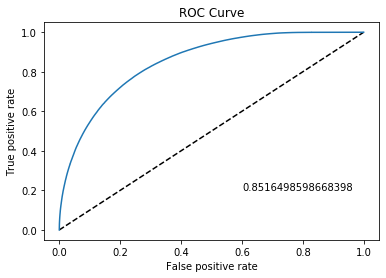

In [62]:
clf = MultinomialNB().fit(x_train_tfidf, y_train)

y_predicted = clf.predict(x_validation_tfidf)
y_prob_predicted = clf.predict_proba(x_validation_tfidf)
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_validation, y_predicted)}')

fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_prob_predicted[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title("ROC curve")
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

### SGDClassifier  using TfidfTransformer

Our model's accuracy is 0.8012376219454007


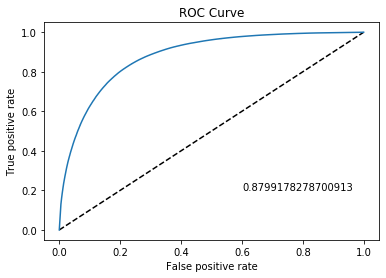

In [63]:
clf = SGDClassifier(tol=1e-3, loss='modified_huber').fit(x_train_tfidf, y_train)

y_predicted = clf.predict(x_validation_tfidf)
y_prob_predicted = clf.predict_proba(x_validation_tfidf)
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_validation, y_predicted)}')

fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_prob_predicted[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title("ROC curve")
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

### SVC using TfidfTransformer

Our model's accuracy is 0.8119122947390056


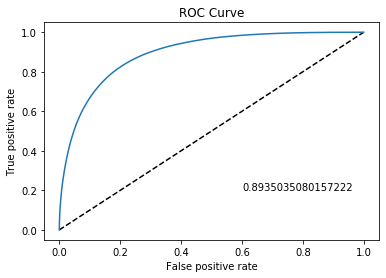

In [64]:
clf = CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', dual=False), cv=3).fit(x_train_tfidf, y_train)

y_predicted = clf.predict(x_validation_tfidf)
y_prob_predicted = clf.predict_proba(x_validation_tfidf)
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_validation, y_predicted)}')

fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_prob_predicted[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title("ROC curve")
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

### Logistic Regression using TfidfTransformer

Our model's accuracy is 0.8122264716029627


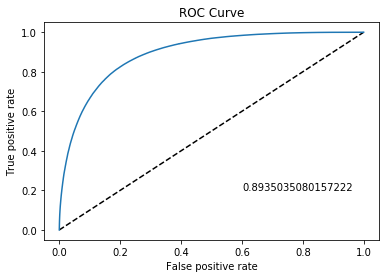

In [65]:
clf = LogisticRegression().fit(x_train_tfidf, y_train)

y_predicted = clf.predict(x_validation_tfidf)
y_prob_predicted = clf.predict_proba(x_validation_tfidf)
print(f'Our model\'s accuracy is {metrics.accuracy_score(y_validation, y_predicted)}')

fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_prob_predicted[:,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plot_roc(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

For the rest, we use Logistic regression to improve our model

## Feature engineering (can later test on NN model)
### Stop words

In [26]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    """Helper function to compute accuracy for some pipeline"""
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [27]:
tfidf_transformer = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100000,10000)

def nfeature_accuracy_checker(vectorizer=tfidf_transformer, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    """Helper to get accuracies for different number of features"""
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append(nfeature_accuracy)
    return result

In [28]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_with_stop = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
accuracy score: 79.53%
train and test time: 6.44s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 79.60%
train and test time: 6.58s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 79.61%
train and test time: 5.23s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 79.65%
train and test time: 4.99s
--------------------------------------------------------------------------------
Validation result for 500

In [29]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_without_stop = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
accuracy score: 77.29%
train and test time: 4.15s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 77.44%
train and test time: 4.28s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 77.53%
train and test time: 4.55s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 77.57%
train and test time: 4.58s
--------------------------------------------------------------------------------
Validation result for 

In [30]:
%%time
custom_stop_words = {'a', 'and', 'i', 'is', 'it', 'for', 'me', 'multistop', 'my', 'of', 's', 'the', 'that',\
                     'to', 'you','down', 'have', 'hers', 'their', 'for', 'themselves', 'in', 'so', 'do', 'm',\
                     'such', 'here', 'be', 'at','being', 'does', 'a', 'while', 'with', 'itself', 'its', 'am',\
                     'above', 'myself', 'own','same', 'as', 'my', 'which', 'to', 'were', 'did', 'after', 'his',\
                     'are','they', 'other', 'theirs'}
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS\n")
feature_result_custom_stop = nfeature_accuracy_checker(stop_words=custom_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
accuracy score: 79.21%
train and test time: 4.26s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 79.22%
train and test time: 4.57s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 79.28%
train and test time: 5.45s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 79.28%
train and test time: 4.92s
--------------------------------------------------------------------------------
Validation resu

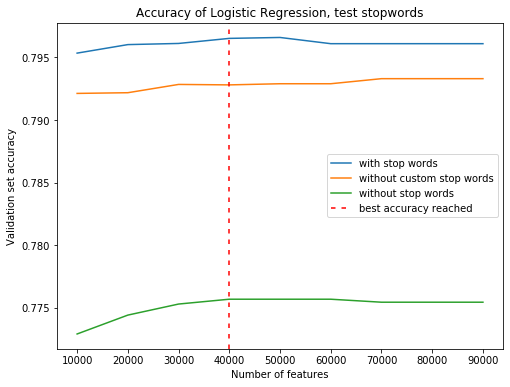

In [32]:
plt.figure(figsize=(8,6))
plt.plot(n_features, feature_result_with_stop, label='with stop words')
plt.plot(n_features, feature_result_custom_stop,label='without custom stop words')
plt.plot(n_features, feature_result_without_stop,label='without stop words')
ind = n_features[np.argmax(feature_result_without_stop)]
plt.axvline(x=ind, color='red', dashes= (3, 4, 3, 4), label='best accuracy reached' )
plt.title("Accuracy of Logistic Regression, test stopwords")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

### N Grams

In [33]:
%%time
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
accuracy score: 81.09%
train and test time: 10.48s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 81.62%
train and test time: 10.60s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 81.67%
train and test time: 11.08s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 81.75%
train and test time: 11.02s
--------------------------------------------------------------------------------
Validation result for 

In [34]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
accuracy score: 80.98%
train and test time: 21.75s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 81.41%
train and test time: 24.17s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 81.57%
train and test time: 21.18s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 81.67%
train and test time: 20.85s
--------------------------------------------------------------------------------
Validation result for

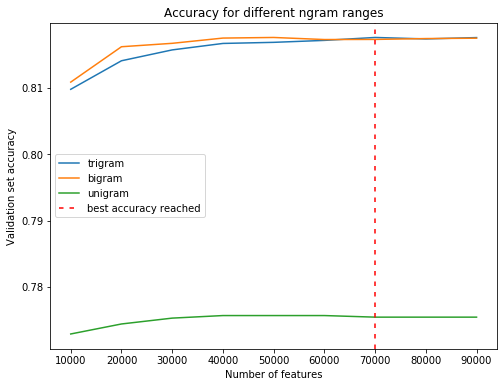

In [35]:
plt.figure(figsize=(8,6))
plt.plot(n_features, feature_result_tg,label='trigram')
plt.plot(n_features, feature_result_bg,label='bigram')
plt.plot(n_features, feature_result_without_stop, label='unigram')
ind = n_features[np.argmax(feature_result_tg)]
plt.axvline(x=ind, color='red', dashes= (3, 4, 3, 4), label='best accuracy reached' )
plt.title("Accuracy for different ngram ranges")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [36]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    """Helper function to train and validate some model"""
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['actual_negative', 'actual_positive'],
                         columns=['predicted_negative','predicted_positive'])
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print( confusion)
    print ("-"*80)
    print( "Classification Report\n")
    print( classification_report(y_test, y_pred, target_names=['negative','positive']))
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax = sns.heatmap(confusion ,annot_kws={"size": 16}, linewidths=.5,fmt="d", cmap="YlGnBu", annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix of our best performing model')
    plt.xlabel("Prediction");
    plt.ylabel("Actual label");

accuracy score: 81.74%
--------------------------------------------------------------------------------
Confusion Matrix

                 predicted_negative  predicted_positive
actual_negative               21717                5687
actual_positive                4247               22746
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.84      0.79      0.81     27404
   positive       0.80      0.84      0.82     26993

avg / total       0.82      0.82      0.82     54397



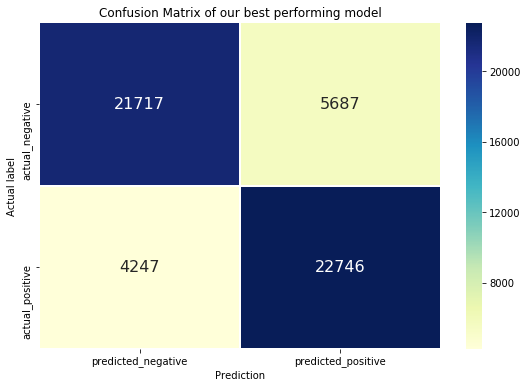

In [37]:
# test our best performing model
vectorizer = TfidfVectorizer(max_features=80000,ngram_range=(1, 3))
classifier = LogisticRegression()

bg_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
    
train_test_and_evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

## Test submission

In [81]:
with open('data/test_data.txt',"r") as file:
    df_unknown = file.read().split('\n')
df_unknown = pd.DataFrame({'tweet' : df_unknown})[:len(df_unknown)-1]
df_unknown.index += 1 
df_unknown['tweet'] = df_unknown['tweet'].apply(lambda x : str(x).split(',', maxsplit=1)[1])
df_unknown

,tweet
1,sea doo pro sea scooter ( sports with the port...
2,<user> shucks well i work all week so now i ca...
3,i cant stay away from bug thats my baby
4,<user> no ma'am ! ! ! lol im perfectly fine an...
5,"whenever i fall asleep watching the tv , i alw..."
...,...
9996,had a nice time w / my friend lastnite
9997,<user> no it's not ! please stop !
9998,not without my daughter ( dvd two-time oscar (...
9999,<user> have fun in class sweetcheeks


In [82]:
df_unknown['tweet'] = df_unknown['tweet'].apply(tweet_cleaner)
df_unknown.to_csv("./data/test_cleaned.csv")

In [83]:
vectorizer = TfidfVectorizer(max_features=120000,ngram_range=(1, 3))

x_train_tfidf = vectorizer.fit_transform(x_train)

clf = LogisticRegression().fit(x_train_tfidf, y_train)

X_to_predict = df_unknown['tweet']
X_to_predict = vectorizer.transform(X_to_predict)

y_predicted = clf.predict(X_to_predict)
y_predicted[y_predicted == 0] = -1 #replace 0 to -1

In [84]:
create_csv_submission([x for x in range(1,len(y_predicted)+1)],y_predicted,"output_full_new_clean.csv")